In [213]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.pipeline import (Pipeline, FeatureUnion)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder)
from sklearn_features.transformers import DataFrameSelector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [214]:
df = pd.read_csv(r"Data\train.csv")
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",23,7,11.5,3.0,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",18,7,11.5,3.0,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,5729,2,"Auto Loan, and Student Loan",27,6,11.5,3.0,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",20,NaN,11.5,3.0,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


In [215]:
print(f"Number Of Rows: {df.shape[0]}")
print(f"Number Of Columns: {df.shape[1]}")

Number Of Rows: 100000
Number Of Columns: 28


In [216]:
df = df.drop(columns=["ID", "Customer_ID", "Name", "SSN", "Type_of_Loan", "Changed_Credit_Limit", "Credit_Mix", "Payment_Behaviour"])

In [217]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   object 
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Outstanding_Debt          100000 non-null  object 
 13  Credit_Utilization_Ratio  100000 non-null  fl

In [218]:
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

columnsToConvert = ['Age',
    'Annual_Income',
    'Num_of_Loan',
    'Num_of_Delayed_Payment',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Monthly_Balance']

df = convert_to_numeric(df, columnsToConvert)

In [219]:
missingRatio = df.isnull().sum() * 100 / df.shape[0]
missingRatio

Month                        0.000
Age                          4.939
Occupation                   0.000
Annual_Income                6.980
Monthly_Inhand_Salary       15.002
Num_Bank_Accounts            0.000
Num_Credit_Card              0.000
Interest_Rate                0.000
Num_of_Loan                  4.785
Delay_from_due_date          0.000
Num_of_Delayed_Payment       9.746
Num_Credit_Inquiries         1.965
Outstanding_Debt             1.009
Credit_Utilization_Ratio     0.000
Credit_History_Age           9.030
Payment_of_Min_Amount        0.000
Total_EMI_per_month          0.000
Amount_invested_monthly      8.784
Monthly_Balance              1.209
Credit_Score                 0.000
dtype: float64

In [220]:
dupl = df.duplicated()
dupl[dupl == True]

Series([], dtype: bool)

In [221]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,95061.0,110.934505,6.894079e+02,-500.000000,24.000000,33.000000,42.000000,8.698000e+03
Annual_Income,93020.0,178578.964199,1.442878e+06,7005.930000,19435.600000,37550.740000,72843.380000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,95215.0,2.780339,6.250094e+01,-100.000000,1.000000,3.000000,5.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,90254.0,31.033051,2.269558e+02,-3.000000,9.000000,14.000000,18.000000,4.397000e+03
Num_Credit_Inquiries,98035.0,27.754251,1.931773e+02,0.000000,3.000000,6.000000,9.000000,2.597000e+03


In [222]:
min_age = 0
max_age = 120

df["Age"] = df["Age"].apply(lambda x: x if min_age <= x <= max_age else np.nan)

medAge = df["Age"].median()
df["Age"] = df["Age"].replace(to_replace=np.nan, value=medAge)

In [223]:
Num_Bank_AccountsMode = df["Num_Bank_Accounts"].mode()[0]

df["Num_Bank_Accounts"] = df["Num_Bank_Accounts"].apply(lambda x: Num_Bank_AccountsMode if x < 0 else x)

In [224]:
df["Delay_from_due_date"] = df["Delay_from_due_date"].apply(lambda x: 0 if x < 0 else x)

In [225]:
medianNumLoan = df[df["Num_of_Loan"] > 0]["Num_of_Loan"].median()
df["Num_of_Loan"] = df["Num_of_Loan"].apply(lambda x: medianNumLoan if x < 0 else x)

In [226]:
interest_rate_median = df["Interest_Rate"].median()
df["Interest_Rate"] = df["Interest_Rate"].apply(lambda x: interest_rate_median if x > 50 or x < 1 else x)

In [227]:
pattern = r'[^a-zA-Z0-9\s.,!?;:"\'\-\(\)]'

for col in df.columns:
    non_regular = df[col].astype(str).str.contains(pattern, regex=True, na=False)
    if non_regular.any():
        print(f"Non-regular marks found in column: {col}")
        print(df[non_regular][col])

Non-regular marks found in column: Occupation
8              _______
16             _______
18             _______
20             _______
29             _______
             ...      
99972    Media_Manager
99973    Media_Manager
99974    Media_Manager
99975    Media_Manager
99989          _______
Name: Occupation, Length: 13294, dtype: object


In [228]:
valid_occupations = df[df["Occupation"] != "_______"]["Occupation"].mode()[0]
df["Occupation"] = df["Occupation"].replace("_______", value=valid_occupations)

In [229]:
nulls = df.isnull().sum()
col = nulls[nulls > 0].index[0]
df[col].dtype

dtype('float64')

In [230]:
nulls = df.isnull().sum()
nullCols = nulls[nulls > 0].index

nullCatCols = []
nullNumCols = []

for _, col in enumerate(nullCols):
    if df[col].dtype == "O":
        nullCatCols.append(col)
    else:
        nullNumCols.append(col)

print(nullCatCols)
print(nullNumCols)

['Credit_History_Age']
['Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']


In [231]:
def handleNullValues(numCols, CatCols):
    for _, col in enumerate(numCols):
        NumColMedian = df[col].median()
        df[col] = df[col].fillna(value=NumColMedian)

    for _, col in enumerate(CatCols):
        CatColMode = df[col].mode()[0]
        df[col] = df[col].fillna(value=CatColMode)    

handleNullValues(nullNumCols, nullCatCols)

In [232]:
def years_months_to_months(period):
    if pd.isnull(period):
        return period

    parts = period.split(' ')
    years = int(parts[0])
    months = int(parts[3])
    total_months = years * 12 + months
    return total_months

df['credit_history_age_months'] = df['Credit_History_Age'].apply(years_months_to_months)
df.drop(columns=['Credit_History_Age'], inplace=True)

In [233]:
catCols = df.select_dtypes(include="object")
numCols = df.select_dtypes(include=["int", "float"])

In [234]:
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,credit_history_age_months
0,January,23.0,Scientist,19114.12,1824.843333,3,4,3.0,4.0,3,7.0,4.0,809.98,26.822620,No,49.574949,80.415295,312.494089,Good,265
1,February,23.0,Scientist,19114.12,3093.745000,3,4,3.0,4.0,0,14.0,4.0,809.98,31.944960,No,49.574949,118.280222,284.629162,Good,191
2,March,33.0,Scientist,19114.12,3093.745000,3,4,3.0,4.0,3,7.0,4.0,809.98,28.609352,No,49.574949,81.699521,331.209863,Good,267
3,April,23.0,Scientist,19114.12,3093.745000,3,4,3.0,4.0,5,4.0,4.0,809.98,31.377862,No,49.574949,199.458074,223.451310,Good,268
4,May,23.0,Scientist,19114.12,1824.843333,3,4,3.0,4.0,6,14.0,4.0,809.98,24.797347,No,49.574949,41.420153,341.489231,Good,269


<Axes: xlabel='Num_Credit_Card', ylabel='Density'>

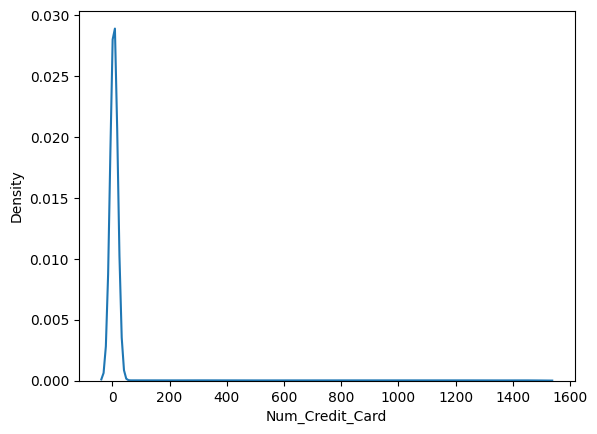

In [235]:
sns.kdeplot(df["Num_Credit_Card"])

## Numerical Features Distribution

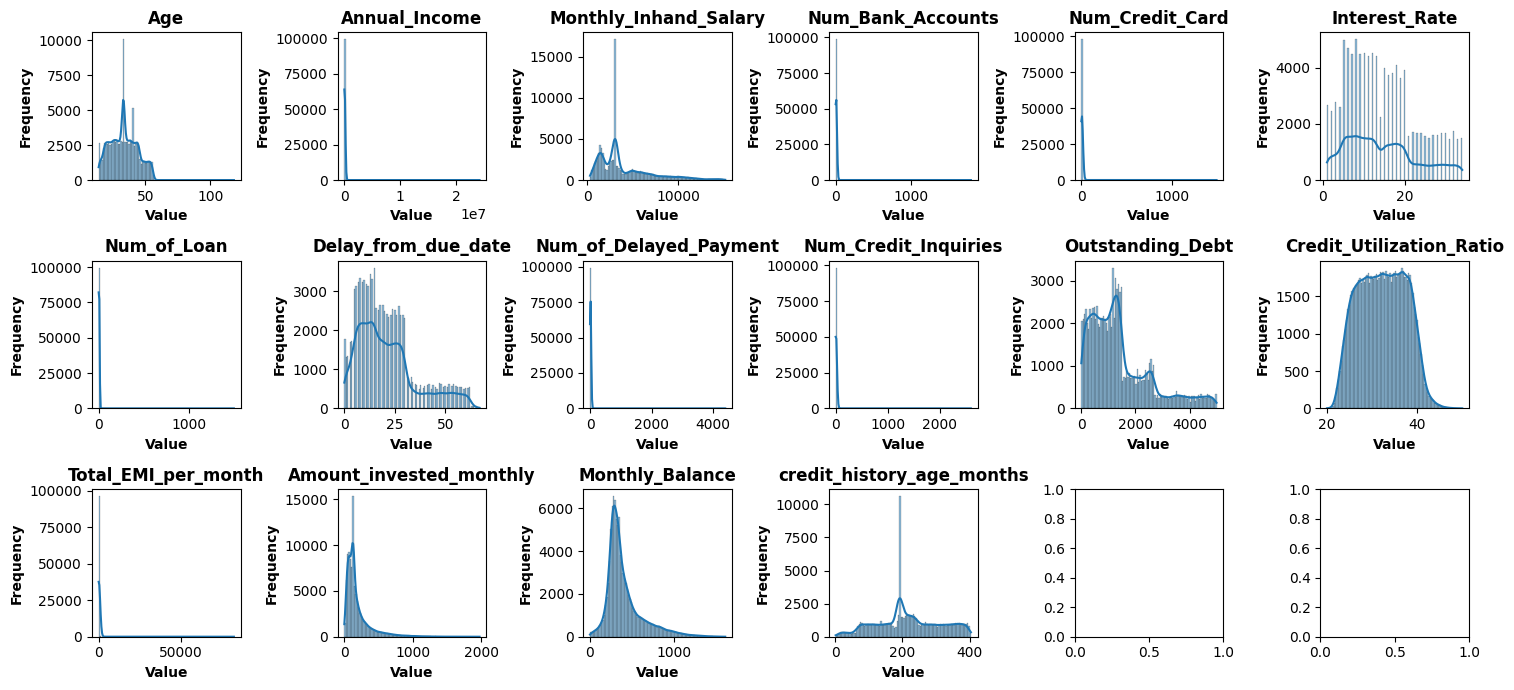

In [236]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15, 7))
axes = axes.flatten()

for index, col in enumerate(numCols.columns):
    sns.histplot(numCols[col], ax=axes[index], kde=True, bins=100)
    axes[index].set_title(f"{col}", fontweight="bold")
    axes[index].set_xlabel("Value", fontweight="bold")
    axes[index].set_ylabel("Frequency", fontweight="bold")
    
plt.tight_layout()
plt.show()

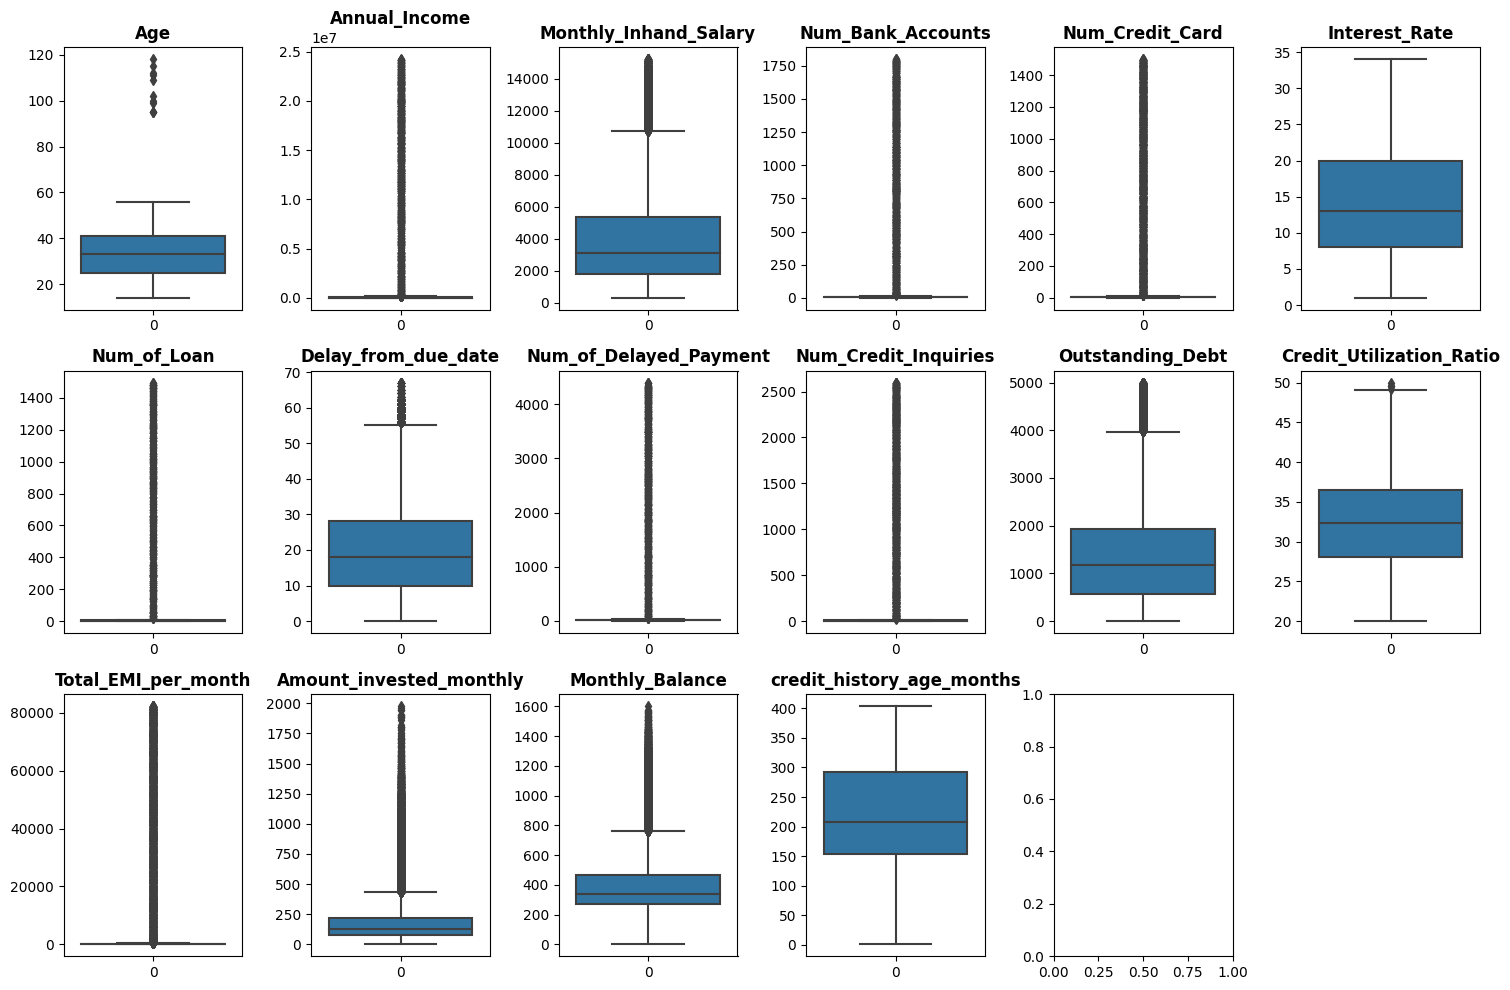

In [237]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15, 10))
axes = axes.flatten()

for index, col in enumerate(numCols.columns):
    sns.boxplot(numCols[col], ax=axes[index])
    axes[index].set_title(f"{col}", fontweight="bold")
    # axes[index].set_xlabel("Value", fontweight="bold")
    # axes[index].set_ylabel("Frequency", fontweight="bold")
    
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

In [238]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, numCols.columns)

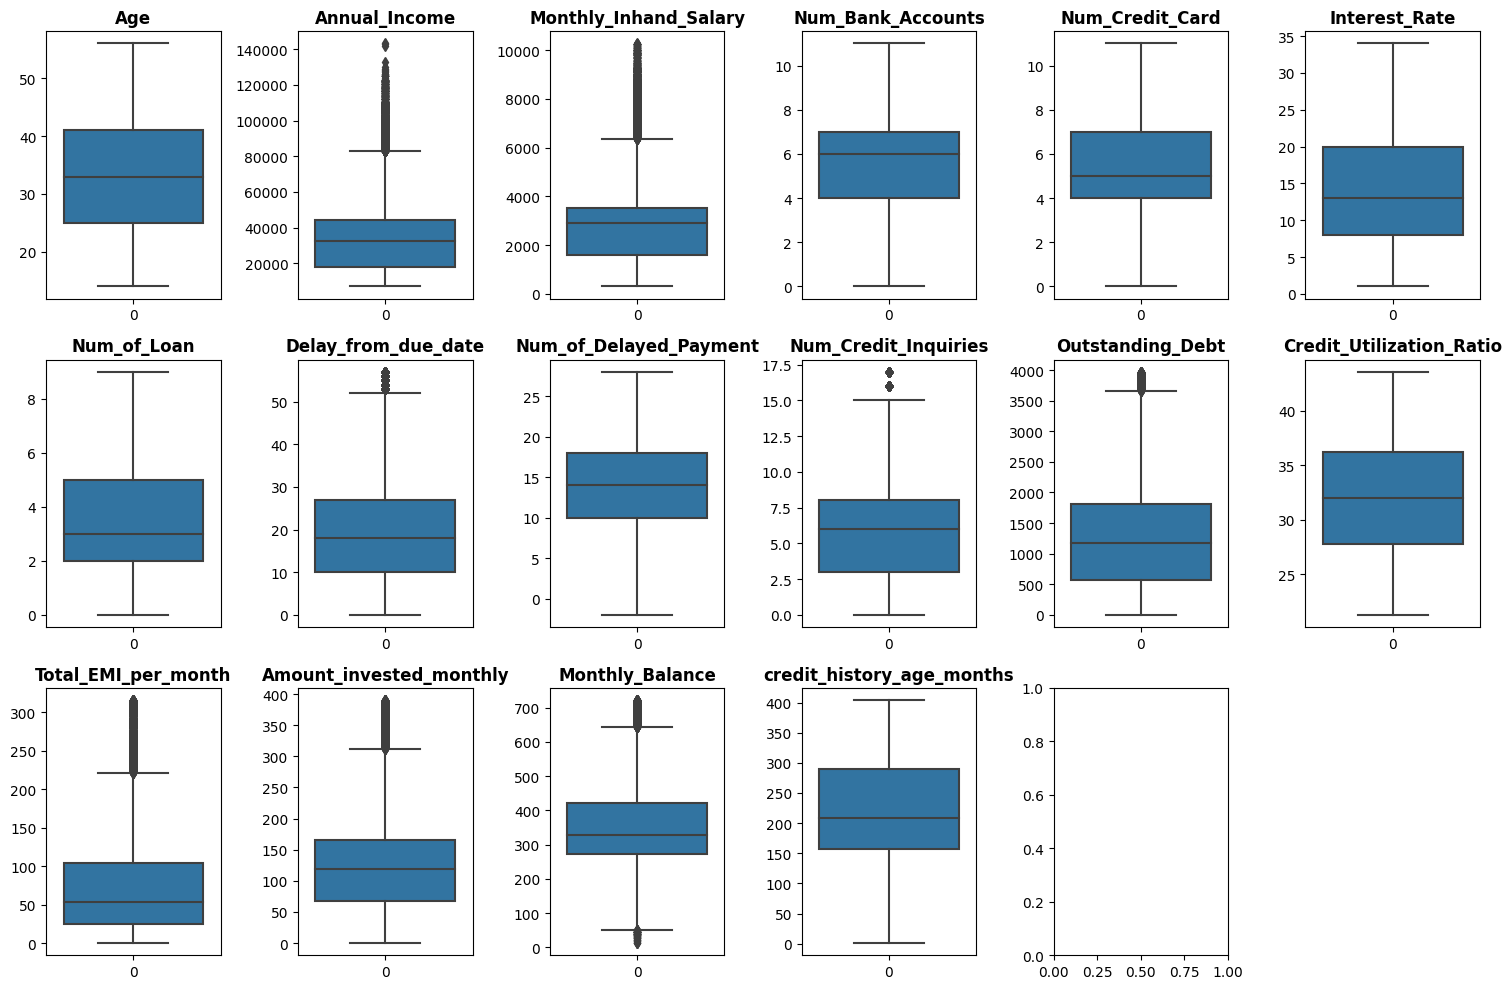

In [239]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15, 10))
axes = axes.flatten()

for index, col in enumerate(numCols.columns):
    sns.boxplot(df[col], ax=axes[index])
    axes[index].set_title(f"{col}", fontweight="bold")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

In [240]:
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,credit_history_age_months
0,January,23.0,Scientist,19114.12,1824.843333,3,4,3.0,4.0,3,7.0,4.0,809.98,26.822620,No,49.574949,80.415295,312.494089,Good,265
1,February,23.0,Scientist,19114.12,3093.745000,3,4,3.0,4.0,0,14.0,4.0,809.98,31.944960,No,49.574949,118.280222,284.629162,Good,191
2,March,33.0,Scientist,19114.12,3093.745000,3,4,3.0,4.0,3,7.0,4.0,809.98,28.609352,No,49.574949,81.699521,331.209863,Good,267
3,April,23.0,Scientist,19114.12,3093.745000,3,4,3.0,4.0,5,4.0,4.0,809.98,31.377862,No,49.574949,199.458074,223.451310,Good,268
4,May,23.0,Scientist,19114.12,1824.843333,3,4,3.0,4.0,6,14.0,4.0,809.98,24.797347,No,49.574949,41.420153,341.489231,Good,269


### Calculate Skewness & Kurtosis

In [241]:
summary = pd.DataFrame({
    "Skewness": df.skew(numeric_only=True),
    "Kurtosis": df.kurtosis(numeric_only=True)
})

summary

,Skewness,Kurtosis
Age,0.168094,-0.748180
Annual_Income,1.095251,0.837249
Monthly_Inhand_Salary,1.108096,1.112076
Num_Bank_Accounts,-0.204632,-0.612801
Num_Credit_Card,0.251977,-0.277042
Interest_Rate,0.510070,-0.574557
Num_of_Loan,0.454190,-0.254437
Delay_from_due_date,0.859720,0.249284
Num_of_Delayed_Payment,-0.258350,-0.226729
Num_Credit_Inquiries,0.381696,-0.558370


In [243]:
def log_transform(x):
    return np.log1p(x) 

def sqrt_transform(x):
    return np.sqrt(x)

def square_transform(x):
    return x ** 2

def yeo_johnson_transform(x):
    pt = PowerTransformer(method='yeo-johnson')
    return pt.fit_transform(x.reshape(-1, 1)).flatten()

def transform_column(df, column_name, skewness):
    min_value = df[column_name].min()

    if skewness > 1: 
        if min_value > 0:
            df[column_name] = log_transform(df[column_name])
        else:
            
            df[column_name] = yeo_johnson_transform(df[column_name].values)
    elif skewness < -1:  
        df[column_name] = square_transform(df[column_name])
    else:  
        if skewness > 0:
            df[column_name] = sqrt_transform(df[column_name])

In [244]:
for i in summary.index:
    transform_column(df, i, summary.loc[i, "Skewness"])

In [245]:
summary = pd.DataFrame({
    "Skewness": df.skew(numeric_only=True),
    "Kurtosis": df.kurtosis(numeric_only=True)
})

summary

,Skewness,Kurtosis
Age,-0.130727,-0.748098
Annual_Income,-0.143625,-0.631176
Monthly_Inhand_Salary,-0.339637,-0.197319
Num_Bank_Accounts,-0.204632,-0.612801
Num_Credit_Card,-0.318823,0.156695
Interest_Rate,-0.113305,-0.624350
Num_of_Loan,-0.820511,0.494258
Delay_from_due_date,-0.083975,-0.053387
Num_of_Delayed_Payment,-0.258350,-0.226729
Num_Credit_Inquiries,-0.658499,0.047712


In [246]:
# Variance Inflation Factor (VIF)
# handling multicollinearity    

X = numCols
X = sm.add_constant(X)

vif = pd.DataFrame()
vif['variable'] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [247]:
# VIF < 5: No significant multicollinearity.
# 5 ≤ VIF < 10: Moderate multicollinearity; review and possibly address.
# VIF ≥ 10: Severe multicollinearity; take corrective action.

vif

,variable,VIF
0,const,77.389651
1,Age,1.064300
2,Annual_Income,1.001129
3,Monthly_Inhand_Salary,3.522354
4,Num_Bank_Accounts,1.000465
5,Num_Credit_Card,1.000177
6,Interest_Rate,2.005596
7,Num_of_Loan,1.001058
8,Delay_from_due_date,1.725161
9,Num_of_Delayed_Payment,1.000309


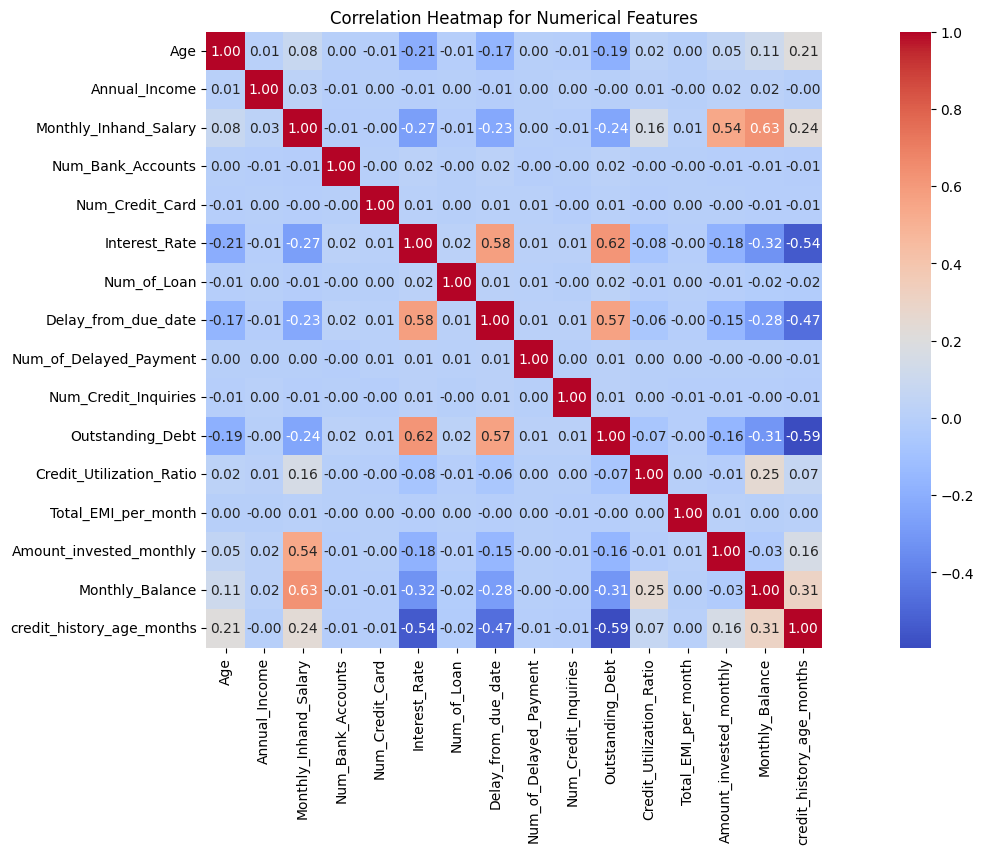

In [248]:
corr_matrix = numCols.corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

In [249]:
le = LabelEncoder()

df["Credit_Score"] = le.fit_transform(df["Credit_Score"])

In [250]:
X = df.drop(columns="Credit_Score")
y = df["Credit_Score"]

In [251]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [252]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(50641, 19)
(50641,)
(12661, 19)
(12661,)


## Preprocessing

In [253]:
catCols = catCols.drop(columns="Credit_Score").columns.to_list()
numCols = numCols.columns.tolist()

In [256]:
# Numerical pipeline
numPipeline = Pipeline(steps=[
    ("imputing", SimpleImputer(strategy="median")),
    ("Scaling", StandardScaler())
])
# Categorical pipeline
catPipeline = Pipeline(steps=[
    ("imputing", SimpleImputer(strategy="most_frequent")), 
    ("encoding", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])
# Total Pipeline
totalPipeline = ColumnTransformer(transformers=[
    ("Num", numPipeline, numCols),
    ("Cat", catPipeline, catCols)
])

In [258]:
X_train = totalPipeline.fit_transform(X_train)
X_valid = totalPipeline.transform(X_valid)

## Modeling

In [263]:
XGBoost = XGBClassifier(objective="multi:softmax", 
                        num_class=3,
                        alpha=1.0,
                        lambda_=1.0,
                        n_estimator=50,
                        learning_rate=0.1, 
                        max_depth=6, 
                        min_child_weight=1)
XGBoost.fit(X_train, y_train)

XGBClassifier(alpha=1.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda_=1.0, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=50, n_estimators=None, ...)

In [264]:
y_train_pred = XGBoost.predict(X_train)
y_valid_pred = XGBoost.predict(X_valid)

train_report = classification_report(y_train, y_train_pred)
valid_report = classification_report(y_valid, y_valid_pred)
print("Train Classification Report")
print(train_report)
print("Validation Classification Report")
print(valid_report)

Train Classification Report
              precision    recall  f1-score   support

           0       0.66      0.61      0.64      8177
           1       0.77      0.76      0.77     15185
           2       0.79      0.81      0.80     27279

    accuracy                           0.76     50641
   macro avg       0.74      0.73      0.73     50641
weighted avg       0.76      0.76      0.76     50641

Validation Classification Report
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      2054
           1       0.74      0.73      0.74      3757
           2       0.76      0.77      0.77      6850

    accuracy                           0.73     12661
   macro avg       0.70      0.69      0.69     12661
weighted avg       0.73      0.73      0.73     12661



In [269]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



ANNModel = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(3, activation="softmax"),
])

ANNModel.compile(loss='sparse_categorical_crossentropy', 
                optimizer="adam", 
                metrics=['Accuracy'])

ANNModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,147 (63.07 KB)

 Trainable params: 16,147 (63.07 KB)

 Non-trainable params: 0 (0.00 B)

In [270]:
ANNModelHistory = ANNModel.fit(
    X_train,                        
    y_train,                        
    validation_data=(X_valid, y_valid),  
    epochs=20,                      
    batch_size=32                  
)

Epoch 1/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - Accuracy: 0.6549 - loss: 0.7507 - val_Accuracy: 0.6798 - val_loss: 0.6834
Epoch 2/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - Accuracy: 0.6930 - loss: 0.6706 - val_Accuracy: 0.6905 - val_loss: 0.6709
Epoch 3/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Accuracy: 0.6968 - loss: 0.6559 - val_Accuracy: 0.6974 - val_loss: 0.6577
Epoch 4/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Accuracy: 0.7064 - loss: 0.6370 - val_Accuracy: 0.6954 - val_loss: 0.6591
Epoch 5/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Accuracy: 0.7090 - loss: 0.6310 - val_Accuracy: 0.6971 - val_loss: 0.6496
Epoch 6/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Accuracy: 0.7128 - loss: 0.6201 - val_Accuracy: 0.6988 - val_loss: 0.6488
Epoch 7/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - Accuracy: 0.7218 - loss: 0.6066 - val_Accuracy: 0.6995 - val_loss: 0.6483
Epoch 8/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step - Accuracy: 0.7272 - loss: 0.596

In [273]:
y_train_pred_prob = ANNModel.predict(X_train)
y_valid_pred_prob = ANNModel.predict(X_valid)

y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_valid_pred = np.argmax(y_valid_pred_prob, axis=1)


train_report = classification_report(y_train, y_train_pred)
valid_report = classification_report(y_valid, y_valid_pred)

print("Train Classification Report")
print(train_report)
print("Validation Classification Report")
print(valid_report)

1583/1583 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
Train Classification Report
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      8177
           1       0.76      0.80      0.78     15185
           2       0.82      0.79      0.80     27279

    accuracy                           0.78     50641
   macro avg       0.77      0.77      0.77     50641
weighted avg       0.79      0.78      0.78     50641

Validation Classification Report
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      2054
           1       0.69      0.73      0.71      3757
           2       0.75      0.73      0.74      6850

    accuracy                           0.71     12661
   macro avg       0.68      0.68      0.68     12661
weighted avg       0.71      0.71      0.71     12661



In [272]:
y_train_pred

array([[2.7265835e-03, 4.3356508e-01, 5.6370836e-01],
       [9.2665762e-01, 1.0041543e-07, 7.3342256e-02],
       [1.8239506e-04, 7.8550756e-01, 2.1431006e-01],
       ...,
       [8.0700545e-04, 8.0104500e-01, 1.9814800e-01],
       [6.4228868e-01, 2.1673737e-03, 3.5554400e-01],
       [9.1535348e-06, 5.8048487e-01, 4.1950592e-01]], dtype=float32)